# Homework week 6 - Paolo Zinesi

### Outline:
1. Simulation of the full CRM model and comparison of stationary solutions (analytical and numerical with $w=1$)
2. Comparison of full CRM model solutions with and without QSA ($w=10$)
3. QSA when $w=0.1$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.integrate import solve_ivp

## Introduction
We simulate with a Consumer Resource Model (CRM) the dynamics of $S=5$ species populations $n_{\sigma}\, (\sigma=1,\dots,S)$ and $R=5$ resources $c_i\, (i=1,\dots,R)$. The $S+R$ variables time evolution is described by the set of differential equations
$$\begin{cases}
    \dot{n}_{\sigma}=n_{\sigma} \left[ \sum_{i=1}^R v_i\, \alpha_{\sigma i}\, c_i - \delta \right]\\
    \dot{c}_i=w\, c_i\, (1-c_i) - \sum_{\sigma=1}^S n_{\sigma}\, \alpha_{\sigma i}\, c_i\\
  \end{cases}$$
where the functions $s(c_i)=w\, c_i\, (1-c_i/K)$ and $r(c_i)=c_i$ for the resources supply rate and uptake rate, repectively, have been inserted explicitly.

For simplicity we set $v_i = K=1$, while the other parameters take the values:
* Metabolic strategies: $\alpha_{\sigma i} \sim \mathcal{U}(0,0.2)$
* Death rate: $\delta_{\sigma} \equiv \delta = 1.0 \cdot 10^{-5},\, \forall\, \sigma=1,\dots,S$
* Multiplicative constant of the supply rate: $w=\{0.1,1,10\}$

In [2]:
d_rate = 1.0e-2
n_0 = np.random.uniform(1, 20, size=(5,)).astype(int)
c_0 = np.random.uniform(1, 20, size=(5,)).astype(int)

## Stationary solutions
By setting $\dot{n}_{\sigma} = 0 = \dot{c}_i$, a trivial analytical solution is $n_{\sigma}^* = c_i^* = 0$. The non-trivial solutions occur when some $n_{\sigma}^*,\, c_i^*$ satisfy

$$\begin{cases}
    \sum_{i=1}^R \alpha_{\sigma i}\, c_i^* = \delta \\
    c_i^* = 1 - \frac{1}{w} \sum_{\gamma=1}^S n_{\gamma}^* \alpha_{\gamma i} \\
  \end{cases}$$

## Quasi-Static Approximation (QSA)

In the QSA the dynamics of the resources $c_i$ is supposed to be much slower than the dynamics of the population $n_{\sigma}$. By setting $\dot{c}_i=0$, the formula for $c_i$ that is to be substituted into the original $n_{\sigma}$ is

$$ c_i^* = 1 - \frac{1}{w} \sum_{\gamma=1}^S n_{\gamma}(t) \, \alpha_{\gamma i} $$

The differential equation that $n_{\sigma}$ satisfies becomes

$$ \dot{n}_{\sigma} = n_{\sigma}(t) \left[ \sum_{i=1}^R \alpha_{\sigma i}\, c_i^* - \delta \right] 
                    = n_{\sigma}(t) \left[ \sum_{i=1}^R \alpha_{\sigma i} \left( 1 - \frac{1}{w} \sum_{\gamma=1}^S n_{\gamma}(t)\, \alpha_{\gamma i} \right) - \delta \right] $$
    

In [16]:
def QSA_c(alpha_mat, n_t, w=1):
    """
    Resources in the QSA
    
    - alpha_mat: invertible square matrix
    - n_t: vector containing time-dependent populations of all species
    - w: supply rate mutiplicative constant

    Returns a vector containing the resources 'c' in QSA
    """

    return 1 - (1/w) * alpha_mat.T @ n_t


In [17]:
def QSA_dn_dt(t, n_t, alpha_mat, delta_vec, w=1):
    """
    Time derivative of the population number in the QSA
    
    - t: time variable (used by the time integration routine)
    - n_t: vector containing the population numbers (that depend of time)
    - alpha_mat: invertible square matrix
    - delta_vec: vector containing death rates for each species
    - w: supply rate mutiplicative constant

    Returns a vector containing the time derivatives of population numbers 'n' in QSA
    """

    return n_t * ( alpha_mat @ QSA_c(alpha_mat, n_t, w) - delta_vec )


## Full solution
The full set of differential equations is composed by the $S+R$ coupled differential equations presented in the introduction.

In [5]:
def fullCRM_dy_dt(t, y_t, alpha_mat, delta_vec, w=1.0):
    """
    Time derivative of the population number in the QSA
    
    - t: time variable (used by the time integration routine)
    - y_t: vector containing the variables [n,c] (in order)
    - alpha_mat: invertible square matrix
    - delta_vec: vector containing death rates for each species
    - w: supply rate mutiplicative constant

    Returns a vector containing the time derivatives of [n,c] in the full CRM model
    """

    # not valid if S != R 
    if len(y_t)%2 == 1:
        return -1
    
    S_ = len(y_t) // 2
    n_t = y_t[:S_]
    c_t = y_t[S_:]


    return np.concatenate((n_t * (alpha_mat @ c_t - delta_vec), c_t * (w * (1 - c_t) - alpha_mat.T @ n_t)))

## 1. Full CRM simulation and comparison of stationary solutions
$w=1$

In [6]:
w=1.0

# fix the matrix alpha for analytical-numerical comparison
np.random.seed(10)
alpha = np.diag(np.random.uniform(0, 0.2, size=5))
np.random.shuffle(alpha)
print("alpha = \n", alpha)
print()

# simulate time evolution
res = solve_ivp(fullCRM_dy_dt, t_span=(0,1000), y0=np.concatenate((n_0,c_0)), args=(alpha, np.array([d_rate]*5), w))

nonzero_n = np.argwhere(res['y'][:5,-1] > 1e-10).reshape(-1)
nonzero_c = np.argwhere(res['y'][5:,-1] > 1e-10).reshape(-1)

print(f"Simulated stationary solutions: {res['y'][:,-1]}")
print(f"Indexes of non-zero stationary solutions of n: {nonzero_n}")
print(f"Indexes of non-zero stationary solutions of c: {nonzero_c}")

alpha = 
 [[0.         0.         0.12672965 0.         0.        ]
 [0.         0.         0.         0.         0.0997014 ]
 [0.         0.         0.         0.14976078 0.        ]
 [0.         0.00415039 0.         0.         0.        ]
 [0.15426413 0.         0.         0.         0.        ]]

Simulated stationary solutions: [7.26816406 9.02395038 6.23145034 0.01142355 6.06217482 0.06482388
 0.99964179 0.07890813 0.06677316 0.10029949]
Indexes of non-zero stationary solutions of n: [0 1 2 3 4]
Indexes of non-zero stationary solutions of c: [0 1 2 3 4]


In [7]:
# analytical stationary solutions when all variables != 0
c_star = la.inv(alpha) @ (d_rate*np.ones(5))
print("c^* = ", c_star)

n_star = w * la.inv(alpha.T) @ (1 - la.inv(alpha) @ (d_rate*np.ones(5)))
print("n^* = ", n_star)

c^* =  [0.06482388 2.4094122  0.07890813 0.06677316 0.10029949]
n^* =  [   7.26816406    9.02395038    6.23145034 -339.58549568    6.06217482]


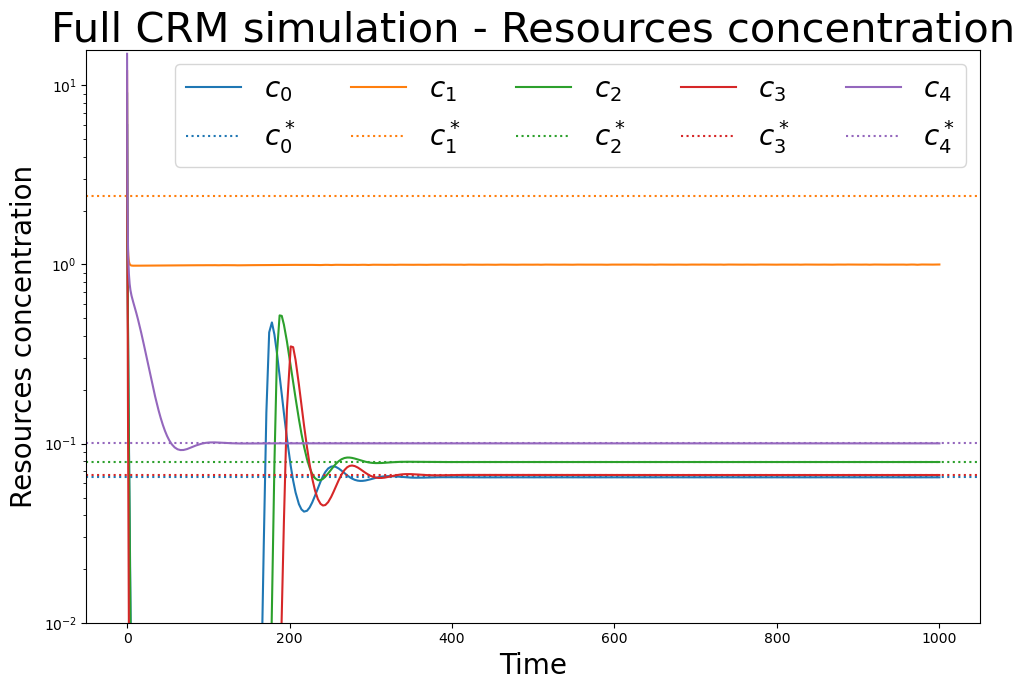

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# resource plots
for i in range(5):
    ax.plot(res['t'], res['y'][i+5,:], label=f"$c_{i}$")
    ax.axhline(c_star[i], ls=':', c='C'+str(i), label=f"$c_{i}^*$")


ax.set_title("Full CRM simulation - Resources concentration", fontsize=30)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Resources concentration", fontsize=20)
ax.set_ylim(1e-2)
ax.set_yscale("log")
ax.legend(fontsize=20, ncol=5)

fig.tight_layout()

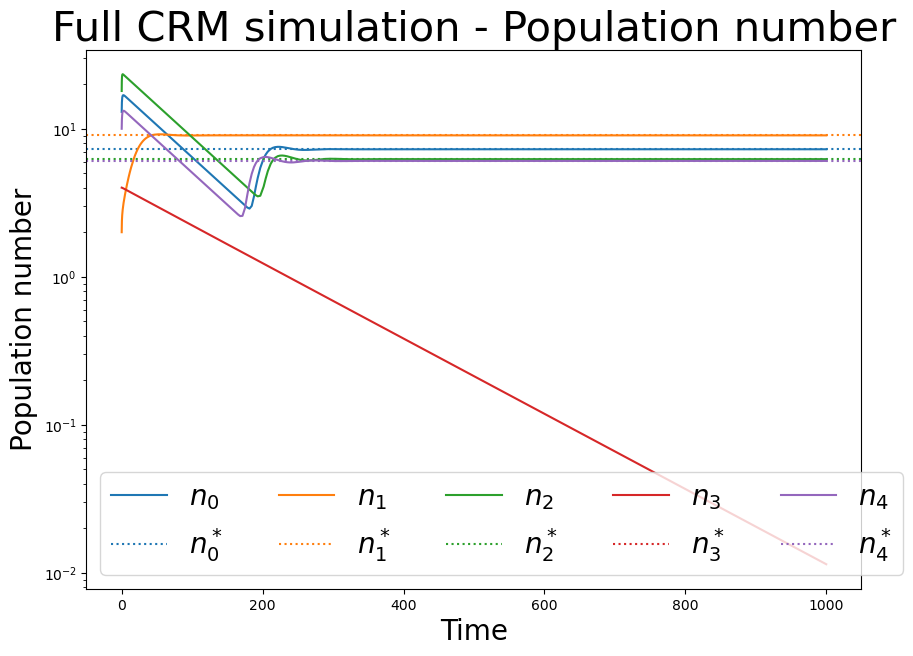

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# population plots
for i in range(5):
    ax.plot(res['t'], res['y'][i,:], label=f"$n_{i}$")
    ax.axhline(n_star[i], ls=':', c='C'+str(i), label=f"$n_{i}^*$")

ax.set_title("Full CRM simulation - Population number", fontsize=30)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Population number", fontsize=20)
ax.set_yscale("log")
ax.legend(fontsize=20, ncol=5)

## 2. Comparison of full CRM and QSA simulations
$w=10$

In [31]:
w = 10.0

# fix the matrix alpha for CRM-QSA comparison
np.random.seed(10)
alpha = np.diag(np.random.uniform(0, 0.2, size=5))
np.random.shuffle(alpha)
print("alpha = \n", alpha)
print()

# simulate time evolution
res_CRM = solve_ivp(fullCRM_dy_dt, t_span=(0,1000), y0=np.concatenate((n_0,c_0)), args=(alpha, np.array([d_rate]*5), w))
res_QSA = solve_ivp(QSA_dn_dt, t_span=(0,1000), y0=n_0, args=(alpha, np.array([d_rate]*5), w))

alpha = 
 [[0.         0.         0.12672965 0.         0.        ]
 [0.         0.         0.         0.         0.0997014 ]
 [0.         0.         0.         0.14976078 0.        ]
 [0.         0.00415039 0.         0.         0.        ]
 [0.15426413 0.         0.         0.         0.        ]]



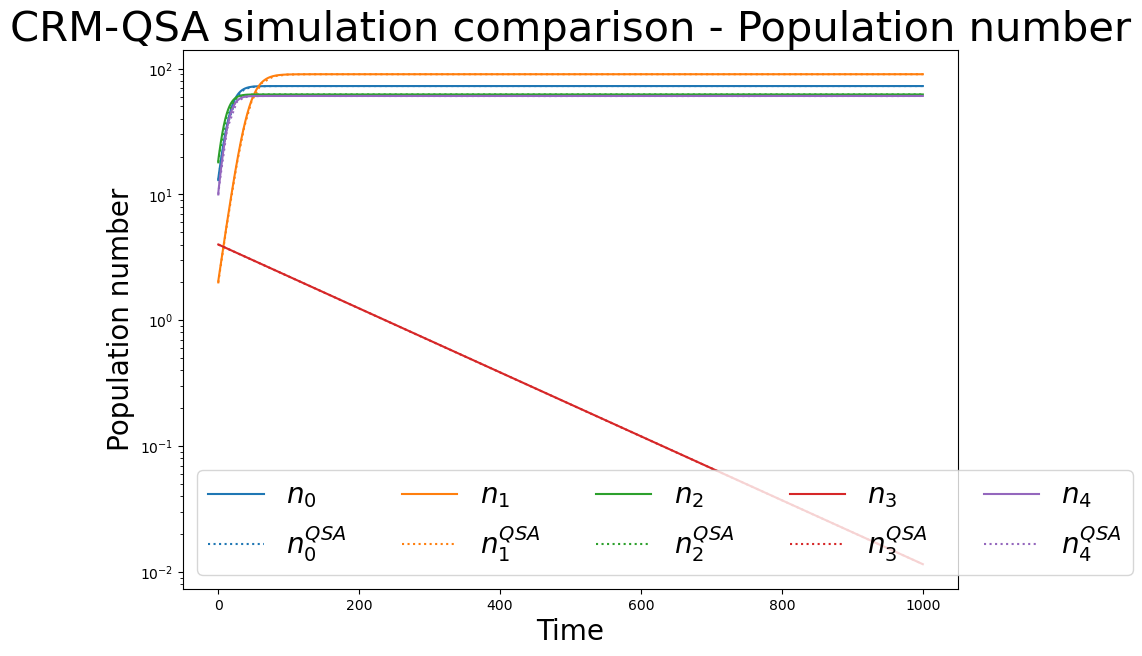

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# population plots
for i in range(5):
    ax.plot(res_CRM['t'], res_CRM['y'][i,:], label=f"$n_{i}$")
    ax.plot(res_QSA['t'], res_QSA['y'][i,:], label=f"$n_{i}^{{QSA}}$", ls=':', c='C'+str(i))

ax.set_title("CRM-QSA simulation comparison - Population number", fontsize=30)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Population number", fontsize=20)
ax.set_yscale("log")
ax.legend(fontsize=20, ncol=5)

### Statistics of population stationary states

In [71]:
w = 10.0
np.random.seed(10)
Nrep = 100
n_stat_CRM, n_stat_QSA = [], []

for rep in range(Nrep):
    # realization of alpha
    #alpha = np.diag(np.random.uniform(0, 0.2, size=5))
    #np.random.shuffle(alpha)
    alpha = np.random.uniform(0, 0.2, size=(5,5,))

    # simulate time evolution
    res_CRM = solve_ivp(fullCRM_dy_dt, t_span=(0,1000), y0=np.concatenate((n_0,c_0)), args=(alpha, np.array([d_rate]*5), w))
    res_QSA = solve_ivp(QSA_dn_dt, t_span=(0,1000), y0=n_0, args=(alpha, np.array([d_rate]*5), w))

    n_stat_CRM.append(res_CRM['y'][:5,-1])
    n_stat_QSA.append(res_QSA['y'][:5,-1])


n_stat_CRM = np.array(n_stat_CRM)
n_stat_QSA = np.array(n_stat_QSA)
    

Text(0, 0.5, 'Population number')

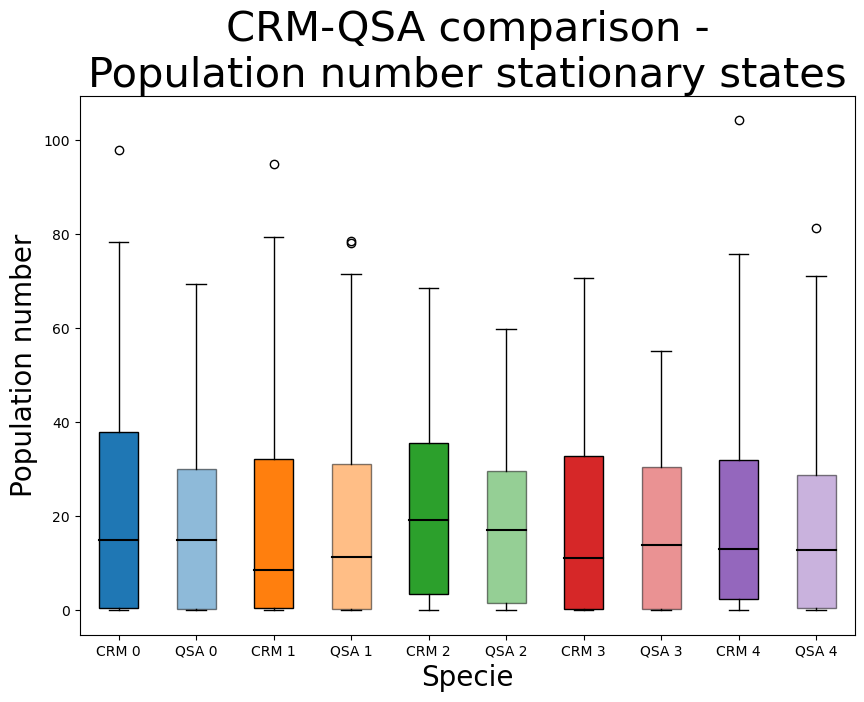

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# population box-plots
b_CRM = ax.boxplot(n_stat_CRM, positions=range(1,5*2,2), labels=["CRM "+str(i) for i in range(5)], patch_artist=True, medianprops = dict(color="black",linewidth=1.5))
b_QSA = plt.boxplot(n_stat_QSA, positions=range(2,5*2+1,2), labels=["QSA "+str(i) for i in range(5)], patch_artist=True, medianprops = dict(color="black",linewidth=1.5))

colors = ["C"+str(i) for i in range(5)]
for patch, color in zip(b_CRM['boxes'], colors):
        patch.set(facecolor=color, alpha=1)
for patch, color in zip(b_QSA['boxes'], colors):
        patch.set(facecolor=color, alpha=0.5)

ax.set_title("CRM-QSA comparison -\nPopulation number stationary states", fontsize=30)
ax.set_xlabel("Specie", fontsize=20)
ax.set_ylabel("Population number", fontsize=20)